In [77]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [78]:
image = cv2.imread('test_image.jpg')
image

array([[[116,  91,  75],
        [194, 174, 134],
        [194, 174, 134],
        ...,
        [248, 238, 215],
        [248, 238, 215],
        [248, 238, 215]],

       [[157, 133, 106],
        [194, 174, 134],
        [194, 174, 134],
        ...,
        [247, 238, 215],
        [247, 238, 215],
        [247, 238, 215]],

       [[185, 163, 127],
        [194, 174, 134],
        [194, 174, 134],
        ...,
        [247, 238, 215],
        [247, 238, 215],
        [247, 238, 215]],

       ...,

       [[ 74,  80,  85],
        [ 74,  80,  85],
        [ 74,  80,  85],
        ...,
        [ 73,  74,  82],
        [ 73,  74,  82],
        [ 73,  74,  82]],

       [[ 74,  80,  85],
        [ 74,  80,  85],
        [ 74,  80,  85],
        ...,
        [ 72,  73,  81],
        [ 72,  73,  81],
        [ 72,  73,  81]],

       [[ 74,  80,  85],
        [ 74,  80,  85],
        [ 74,  80,  85],
        ...,
        [ 72,  73,  81],
        [ 72,  73,  81],
        [ 72,  73,  81]]

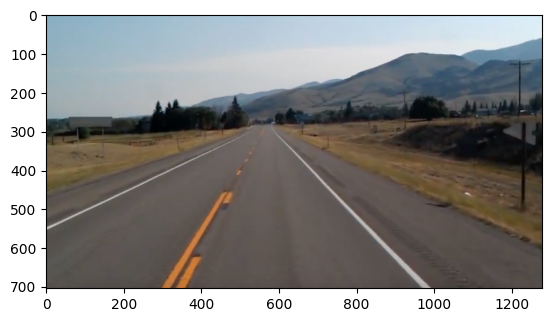

In [79]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.axis('off')
plt.show()

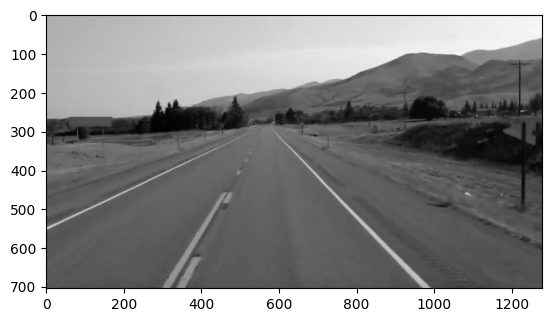

In [80]:
lane_image = np.copy(image_rgb)
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
#plt.axis('off')
plt.show()

Blurring the image using gaussian filtering


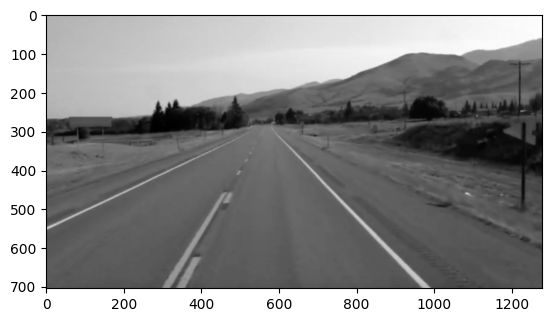

In [81]:
blur = cv2.GaussianBlur(gray,(5,5),0)
plt.imshow(blur, cmap='gray')
#plt.axis('off')
plt.show()


Side by side compare

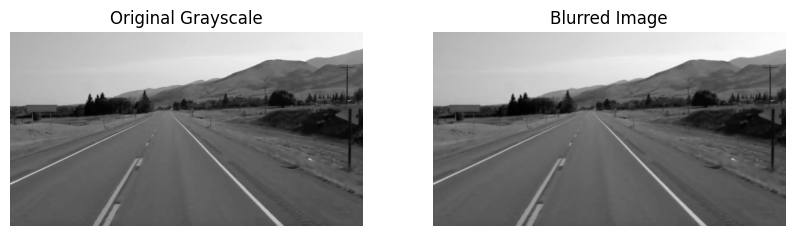

In [82]:
plt.figure(figsize=(10, 5))
# Display the original grayscale image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(gray, cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')  # Hide axes for a cleaner look

# Display the blurred image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(blur, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')  # Hide axes for a cleaner look

# Show the figure with both images
plt.show()

Gradient calculation and finding edge.

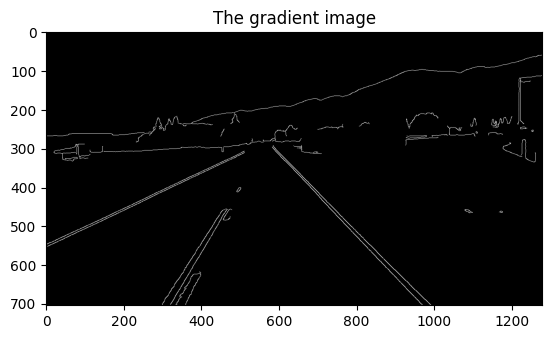

In [83]:
canny = cv2.Canny(blur,50,150)
plt.imshow(canny, cmap='gray')
plt.title("The gradient image")
#plt.axis('off')
plt.show()

Canny Algorithm function


In [84]:
def canny(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    canny = cv2.Canny(blur,50,150)
    return canny

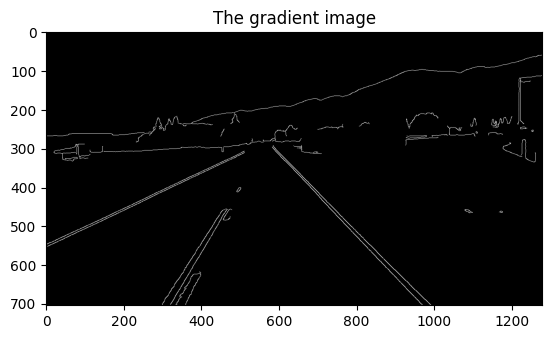

In [85]:
canny_image = canny(lane_image)
plt.imshow(canny_image, cmap='gray')
plt.title("The gradient image")
#plt.axis('off')
plt.show()

In [86]:
def region_of_interest(image_rgb):
      height = image_rgb.shape[0]
      polygons = np.array([((200, height), (1100, height), (550, 250))])
      mask = np.zeros_like(image_rgb)
      cv2.fillPoly(mask, polygons, 255)
      return mask

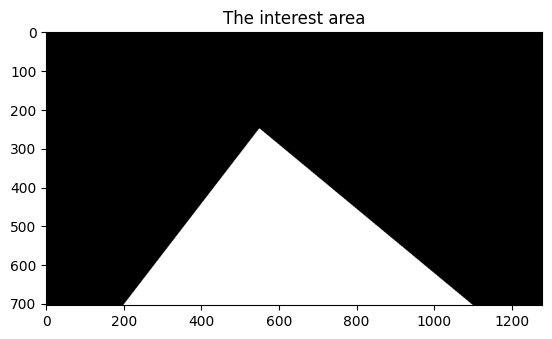

In [87]:
plt.imshow(region_of_interest(canny_image), cmap='gray')
plt.title("The interest area")
#plt.axis('off')
plt.show()

In [88]:
def region_of_interest(image_rgb):
      height = image_rgb.shape[0]
      polygons = np.array([((200, height), (1100, height), (550, 250))])
      mask = np.zeros_like(image_rgb)
      cv2.fillPoly(mask, polygons, 255)
      mask_image = cv2.bitwise_and(image_rgb, mask)
      return mask_image


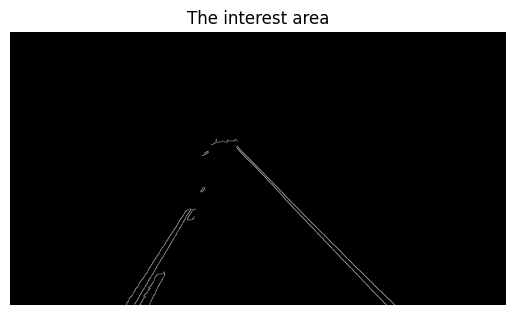

In [89]:
cropped_img = region_of_interest(canny_image)
plt.imshow(cropped_img, cmap='gray')
plt.title("The interest area")
plt.axis('off')
plt.show()

Hough Transform

In [90]:
lines = cv2.HoughLinesP(cropped_img, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

In [91]:
def display_lines(image_rgb, lines):
      line_image = np.zeros_like(image_rgb)
      if lines is not None:
          for line in lines:
              x1, y1, x2, y2 = line.reshape(4)
              cv2.line(line_image, (x1, y1), (x2, y2), (255,0,0), 10)
      return line_image

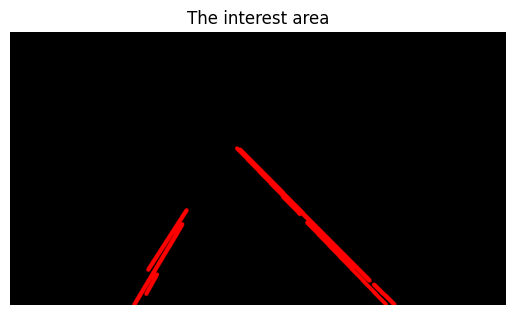

In [92]:
line_image = display_lines(lane_image, lines)
plt.imshow(line_image, cmap='gray')
plt.title("The interest area")
plt.axis('off')
plt.show()

In [93]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1 , 1)

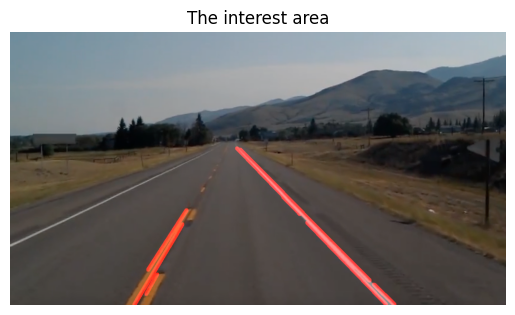

In [94]:
plt.imshow(combo_image, cmap='gray')
plt.title("The interest area")
plt.axis('off')
plt.show()

To get one line

In [95]:
def make_coordinates(image_rgb, line_parameters):
      slope, intercept = line_parameters
      y1 = image_rgb.shape[0]
      y2 = int(y1 * (3/5))
      x1 = int((y1 - intercept)/slope)
      x2 = int((y2 - intercept)/slope)
      return np.array([x1, y1, x2, y2])

In [96]:
def average_slop_intercept(image_rgb, lines):
      left_fit = []
      right_fit = []
      for line in lines:
          x1, y1, x2, y2 = line.reshape(4)
          parameters = np.polyfit((x1, x2), (y1,y2), 1)
          slope = parameters[0]
          intercept = parameters[1]
          if slope < 0:
              left_fit.append((slope, intercept))
          else:
            right_fit.append((slope, intercept))
      left_fit_average = np.average(left_fit, axis=0)
      right_fit_average = np.average(right_fit, axis=0)
      left_line = make_coordinates(image, left_fit_average)
      right_line = make_coordinates(image, right_fit_average)
      return np.array([left_line, right_line])

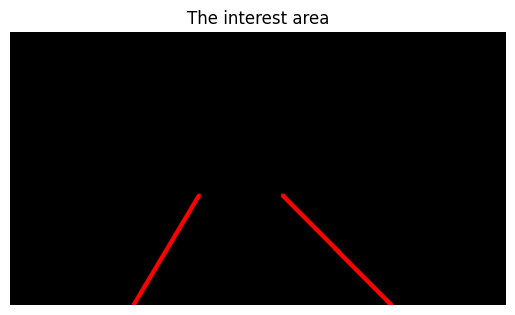

In [97]:
average_lines = average_slop_intercept(lane_image, lines)
line_image = display_lines(lane_image, average_lines)
plt.imshow(line_image, cmap='gray')
plt.title("The interest area")
plt.axis('off')
plt.show()

To get org image again

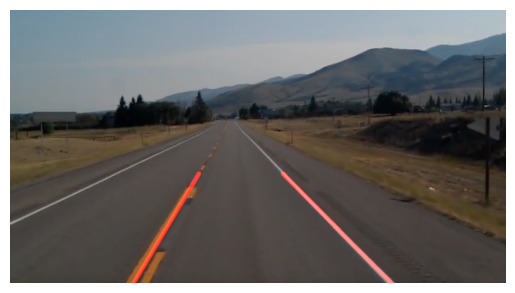

In [98]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1 , 1)
plt.imshow(combo_image, cmap='gray')
plt.axis('off')
plt.show()

In a video